# LowCarb thorax disease classification in Flower

In [9]:
# Download & Unzip data.zip, create data set directory, needs to be done using kaggle, etc.
!mkdir NIH
# In order for this command to work, make sure your api token "kaggle.json" resides in /root/.kaggle/
!kaggle datasets download -d nih-chest-xrays/data
!unzip -q '/content/data.zip' -d '/content/NIH/'
!rm '/content/data.zip'

In [2]:
# Download & Unzip OpenAPI client
!gdown --fuzzy https://drive.google.com/file/d/1RBLe-57mf6N-K7z-nfl8PGP9fvrj3ed8/view?usp=sharing
!unzip -q '/content/python_openapi_client.zip' -d '/content/openapi_client'
!rm '/content/python_openapi_client.zip'

Downloading...
From: https://drive.google.com/uc?id=1RBLe-57mf6N-K7z-nfl8PGP9fvrj3ed8
To: /content/python_openapi_client.zip
100% 267k/267k [00:00<00:00, 106MB/s]


In [12]:
# Copy SSH key to access carbonhack22 GitHub repo -> Will be unnecessary when repo gets public
!cp -r /content/drive/MyDrive/carbonhack22/.ssh ~/
!git clone git@github.com:birnbaum/carbonhack22.git

Cloning into 'carbonhack22'...
remote: Enumerating objects: 353, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 353 (delta 10), reused 16 (delta 4), pack-reused 322
Receiving objects: 100% (353/353), 1.48 MiB | 1.27 MiB/s, done.
Resolving deltas: 100% (169/169), done.


In [13]:
%cd carbonhack22

/content/carbonhack22


## Check GPU availability

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Oct 27 13:12:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install packages

In [15]:
!pip install -q flwr[simulation]

     |████████████████████████████████| 90 kB 8.8 MB/s 
     |████████████████████████████████| 1.0 MB 89.7 MB/s 
     |████████████████████████████████| 54.5 MB 286 kB/s 
     |████████████████████████████████| 4.1 MB 57.3 MB/s 
     |████████████████████████████████| 8.8 MB 78.0 MB/s 
     |████████████████████████████████| 201 kB 71.2 MB/s 
     |████████████████████████████████| 90 kB 10.6 MB/s 
     |████████████████████████████████| 3.0 MB 79.9 MB/s 
     |████████████████████████████████| 57 kB 5.8 MB/s 
     |████████████████████████████████| 128 kB 72.4 MB/s 
     |████████████████████████████████| 291 kB 99.8 MB/s 
     |████████████████████████████████| 58 kB 6.9 MB/s 
     |████████████████████████████████| 468 kB 83.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 

In [16]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./carbon_sdk_client
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 8.8 MB 22.7 MB/s 
     |████████████████████████████████| 140 kB 92.5 MB/s 
     |████████████████████████████████| 54 kB 2.3 MB/s 
     |████████████████████████████████| 9.8 MB 79.2 MB/s 
     |████████████████████████████████| 346 kB 84.5 MB/s 
     |████████████████████████████████| 423 kB 86.6 MB/s 
     |████████████████████████████████| 271 kB 86.6 MB/s 
     |████████████████████████████████| 55 kB 3.7 MB/s 
     |████████

## Imports

In [2]:
import os
import sys
import math
import time
from glob import glob
from PIL import Image
from random import sample
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import flwr as fl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nnqunt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torchvision import transforms as T, models

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

Training on cuda:0


## Data utils

In [3]:
from PIL import Image
from itertools import chain

import numpy as np
import pandas as pd

from torch.utils.data import Dataset

class NIH_Dataset(Dataset):
  """
  Main Dataset class to represent NIH Chest X-Ray data
  ...
  Attributes
  ----------
  data_df: pandas.DataFrame
    A DataFrame that needs to at least have the following two columns:
      1. "path": Holds chest x-ray image locations
      2. "disease_vec": Holds multilabel one-hot encoded vector
  transform: torchvision.transform.Compose
    Image transformations that will be applied to each image when calling "__getitem__"
  """
  def __init__(
    self, 
    data_df,
    transform=None
    ) -> Dataset:
    """
    Parameters
    ----------
    data_df: pandas.DataFrame
      A DataFrame that needs to at least have the following two columns: 
        1. "path": Holds chest x-ray image locations
        2. "disease_vec": Holds multilabel one-hot encoded vector
    transform: torchvision.transform.Compose
      Image transformations that will be applied to each image when calling "__getitem__"
    """
    self.data_df = data_df
    self.transform = transform 

  def __len__(
    self
    ) -> int:
    return len(self.data_df)

  def __getitem__(
    self, 
    idx
    ) -> Tuple[torch.Tensor, np.ndarray]:
    img_file = self.data_df['path'].iloc[idx]
    img = Image.open(img_file).convert('RGB')
    label = np.array(self.data_df.iloc[:,-1].iloc[idx], dtype=float)
    if self.transform:
        img = self.transform(img)

    return img, label

In [4]:
def load_and_preprocess_data_df(
    data_df_root_path: str,
    num_data_samples: int = 11000
    ) -> Tuple[pd.DataFrame, List]:
  """
  Loads and preprocesses NIH DataFrame that holds information of the data, e.g. image labels.

  Parameters
  ----------
  data_df_root_path: str
    This should be the path to the root directory of the NIH data set that, 
    at least, includes the img-file directories and the panda.DataFrame 
    "Data_Entry_2017.csv". The direcotry should have the following structure:

    NIH
      |
      images_0**
      ...
      Data_Entry_2017.csv
      ...
      train_val_list.txt

  num_data_samples: int
    The total number of data points that we want to sample for our data set.
    Maximum is 112120.
  
  Returns
  -------
  preprocessed_xray_df: pd.DataFrame
    Preprocessed pandas DataFrame with column "path"

  all_labels: List
    List containing all labels as strings
  """
  # Load the DataFrame
  all_xray_df = pd.read_csv(
      os.path.join(
          data_df_root_path,
          'Data_Entry_2017.csv'
          )
      )
  # Extract all image paths
  all_image_paths = {
      os.path.basename(x): x for x in 
      glob(os.path.join(data_df_root_path, 'images*', '*', '*.png'))
      }
  # Add image file name column
  all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
  # Count labels
  all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))  
  all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
  all_labels = [x for x in all_labels if len(x)>0]
  for c_label in all_labels:
      if len(c_label)>1: # leave out empty labels
          all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
  MIN_CASES = 1000
  all_labels = [
      c_label for c_label in all_labels if all_xray_df[c_label].sum() > MIN_CASES
      ]
  sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
  sample_weights /= sample_weights.sum()
  preprocessed_xray_df = all_xray_df.sample(num_data_samples, weights=sample_weights)
  # Create one-hot encoding of the vector
  preprocessed_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])
  
  return preprocessed_xray_df, all_labels

In [5]:
def inv_data_transform(
    img: torch.Tensor
    ) -> torch.Tensor:
  """
  Helper function that un-normalizes torch image tensor
  """
  img = img.permute(1,2,0)
  img = img * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])
  return img

def get_data_loaders(
    data_df_root_path: str,
    num_data_samples: int = 11000,
    global_train_frac: float = 0.8,
    local_train_frac: float = 0.8,
    batch_size: int = 32,
    num_clients: int = 10
    ) -> Tuple[Tuple[DataLoader, ...], Tuple[DataLoader, ...], DataLoader, List]:

  """
  Main function to create DataLoaders of the NIH X-Ray data set.
  
  Parameters
  ----------
  data_df_root_path: str
    This should be the path to the root directory of the NIH data set that, 
    at least, includes the img-file directories and the panda.DataFrame 
    "Data_Entry_2017.csv". The direcotry should have the following structure:
    NIHs
      |
      images_0**
      ...
      Data_Entry_2017.csv
      ...
      train_val_list.txt

  num_data_samples: int
    The total number of data points that we want to sample for our data set.
    Maximum is 112120.

  global_train_frac: float
    The fraction of points used for the global training data set, e.g. the data set that will be later split into local client data sets.

  local_train_frac: float
      The fraction of points on each local client used for training.

  batch_size: int
    Batch size on each client

  num_clients: int
    Total number of clients in the FL setup

  Returns
  -------
  trainloaders: List[torch.utils.data.DataLoader, ...]
    List of local training DataLoaders, one for each client

  valloaders: List[torch.utils.data.DataLoader, ...]
    List of local calidation DataLoaders, one for each client

  testloader: torch.utils.data.DataLoader
    Global test DataLoader, for the central server
  
  all_labels: List[str, ...]
    List of all string labels

  preprocessed_data_df: pd.DataFrame
    preprocessed Dataframe that represents the data
  """
  
  preprocessed_xray_df, all_labels = load_and_preprocess_data_df(
      data_df_root_path,
      num_data_samples
  )

  train_data_transform = T.Compose([
    T.RandomRotation((-20,+20)),
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
                ])

  test_data_transform = T.Compose([
    T.Resize((512,512)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
                ])
  
  train_df, test_df = train_test_split(
      preprocessed_xray_df,
      test_size = 1 - global_train_frac,
      random_state = 42,
      stratify = preprocessed_xray_df['Finding Labels'].map( lambda x: x[:4])
  )

  trainset = NIH_Dataset(
      train_df,
      transform = train_data_transform
      )
  
  testset = NIH_Dataset(
      test_df,
      transform = test_data_transform
      )

  # Split training set into `num_clients` partitions to simulate different local datasets
  partition_size = len(trainset) // num_clients
  lengths = [partition_size] * num_clients
  lengths[-1] += len(trainset) - np.sum(lengths)
  datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

  # Split each partition into train/val and create DataLoader
  trainloaders = []
  valloaders = []
  for ds in datasets:      
      len_train = math.ceil(len(ds) * local_train_frac)
      len_val = len(ds) - math.ceil(len(ds) * local_train_frac)
      lengths = [len_train, len_val]
      ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
      trainloaders.append(DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last = True))
      valloaders.append(DataLoader(ds_val, batch_size=batch_size, drop_last = True))
  testloader = DataLoader(testset, batch_size=batch_size)

  return trainloaders, valloaders, testloader, all_labels, preprocessed_xray_df

## Load the data

In [12]:
num_clients = 100

data_df_root_path = '/content/NIH/'
num_data_samples = 112120
global_train_frac = 0.95
local_train_frac = 0.9
batch_size = 25

trainloaders, valloaders, testloader, all_labels, preprocessed_xray_df = get_data_loaders(
    data_df_root_path = data_df_root_path,
    num_clients = num_clients,
    num_data_samples = num_data_samples,
    global_train_frac = global_train_frac,
    local_train_frac = local_train_frac,
    batch_size = batch_size
)

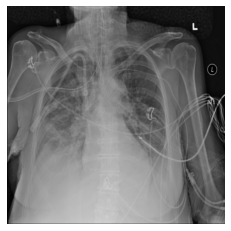

In [13]:
plt.imshow(
    inv_data_transform(
        testloader.dataset[0][0]
    )
)
plt.axis('off');

In [14]:
len(trainloaders[0].dataset), len(valloaders[0].dataset) ,len(testloader.dataset), len(all_labels)

(959, 106, 5607, 13)

## Training utils

In [15]:
def compute_class_freqs(labels):

    labels = np.array(labels)
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

def weighted_loss(pos_weights, neg_weights, y_pred, y_true, epsilon = 1e-7):
    y_pred = torch.sigmoid(y_pred)
    loss = 0.0
    for i in range(len(pos_weights)):
        loss_pos = -1 * torch.mean(pos_weights[i] * y_true[:,i] * torch.log(y_pred[:,i] + epsilon))
        loss_neg = -1 * torch.mean(neg_weights[i] * (1-y_true[:,i]) * torch.log((1-y_pred[:,i]) + epsilon))
        loss += loss_pos + loss_neg
    return loss

def train(
    net,
    trainloader,
    epochs
    ):
    print(f'Entered train function, total num. of epochs: {epochs}')
    # ToDo: Class weights should be different for each client
    freq_pos, freq_neg = compute_class_freqs(preprocessed_xray_df.iloc[:,-1])    
    pos_weights = freq_neg
    neg_weights = freq_pos

    valid_loss_min = np.Inf
    optimizer = torch.optim.Adam(
        net.parameters(),
        lr = 1e-4
        )
    start_time = time.time()
    for i in range(epochs):
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0 
        net.train()
        for j, (images, labels) in enumerate(trainloader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            ps = net(images)
            
            loss = weighted_loss(pos_weights, neg_weights, ps, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(trainloader)
        print("Epoch : {} Train Loss : {:.6f} ".format(i+1,avg_train_loss))
    end_time = time.time()
    time_delta = end_time - start_time
    print('\n')
    print(f'Time to complete local training round: {time_delta}')
    print('\n')

def test(net, testloader, pathology_list):
    
    # ToDo: Class weights should be different for each client
    freq_pos, freq_neg = compute_class_freqs(preprocessed_xray_df.iloc[:,-1])    
    pos_weights = freq_neg
    neg_weights = freq_pos

    per_class_accuracy = [0 for i in range(len(pathology_list))]
    total = 0.0
    loss = 0.0
    with torch.no_grad():
        for images,labels in testloader:
            ps = net(images.to(DEVICE))
            labels = labels.to(DEVICE)
            loss += weighted_loss( pos_weights, neg_weights, ps, labels)
            ps = (ps >= 0.5).float()

            for i in range(ps.shape[1]):
                x1 = ps[:,i:i+1]
                x2 = labels[:,i:i+1]
                per_class_accuracy[i] += int((x1 == x2).sum())

        per_class_accuracy = [(i/len(testloader.dataset)) * 100.0 for i in per_class_accuracy]

    return loss, np.mean(per_class_accuracy)

def get_acc_data(
    class_names,
    acc_list
    ):
    df = pd.DataFrame(list(zip(class_names, acc_list)), columns =['Labels', 'Class Acc.']) 
    return df

## Server utils

In [16]:
def server_eval(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar]
    ):

    # ToDo: Class weights should be different for each client
    freq_pos, freq_neg = compute_class_freqs(preprocessed_xray_df.iloc[:,-1])    
    pos_weights = freq_neg
    neg_weights = freq_pos

    net = init_net().to(DEVICE)

    set_parameters(net, parameters)  # Update model with the latest parameters

    per_class_accuracy = [0 for i in range(len(all_labels))]
    total = 0.0
    loss = 0.0
    with torch.no_grad():
        for images,labels in testloader:
          
            ps = net(images.to(DEVICE))
            labels = labels.to(DEVICE)
            ps = torch.sigmoid(ps)
            ps = (ps >= 0.5).float()
            loss += weighted_loss( pos_weights, neg_weights, ps, labels)

            for i in range(ps.shape[1]):
                x1 = ps[:,i:i+1]
                x2 = labels[:,i:i+1]
                per_class_accuracy[i] += int((x1 == x2).sum())

        per_class_accuracy = [(i/len(testloader.dataset))*100.0 for i in per_class_accuracy]

    test_df = get_acc_data(all_labels, per_class_accuracy)
    print('\nServer eval')
    print(test_df)
    print('\n')

    return loss,  {"mean_class_acc.": np.mean(per_class_accuracy)}

## Client utils

In [17]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader, location: str, *args, **kwargs):
        super(FlowerClient, self).__init__(*args, **kwargs)
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

        ### Giving the client a location upon instantiation
        self.location = location

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        epochs = config["local_epochs"]
        train(self.net, self.trainloader, epochs=epochs)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

    # Make sure the get_properties() method returns the client's location inside a dict
    def get_properties(self, config) -> dict:
        return {'location': self.location}

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    try:
      net.load_state_dict(state_dict, strict=True)
    except:
      print('Skip loading params')

def init_net():  
  net = models.resnet18(
    weights=None
  )
  net.fc = torch.nn.Linear(
      net.fc.in_features,
      len(all_labels)
  )
  return net

available_regions = ['westcentralus', 'ukwest', 'uksouth', 'westeurope', 
                     'westus', 'australiacentral', 'australiaeast', 
                     'swedencentral', 'norwaywest', 'norwayeast', 'northeurope', 
                     'centralus', 'francesouth', 'francecentral']

client_regions_by_cid = [sample(available_regions, 1)[0] for i in range(0, num_clients)]

def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = init_net().to(DEVICE)

    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    return FlowerClient(net, trainloader, valloader, location=client_regions_by_cid[int(cid)])

## Random client selection training

### Training

In [22]:
num_rounds = 2
# 35 local epochs take approx 15 minutes
local_epochs = 5
fraction_fit = 0.03
fraction_evaluate = 0.03
min_fit_clients = 2
min_evaluate_clients = 2

client_resources = {
    "num_cpus": 1,
    "num_gpus": 1
    }

def fit_config(server_round: int):
    config = {
        "server_round": server_round,
        "local_epochs": local_epochs,
    }
    return config

# Create an instance of the model and get the parameters
net = init_net()
params = get_parameters(init_net())

# Pass parameters to the Strategy for server-side parameter initialization
strategy = fl.server.strategy.FedAvg(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_evaluate_clients=min_evaluate_clients,
    min_available_clients=num_clients,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
    evaluate_fn=server_eval,
    on_fit_config_fn=fit_config,
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=num_clients,
    client_resources=client_resources,
    config=fl.server.ServerConfig(num_rounds=num_rounds),
    strategy=strategy
)

INFO flower 2022-10-27 11:43:36,292 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=2, round_timeout=None)
INFO:flower:Starting Flower simulation, config: ServerConfig(num_rounds=2, round_timeout=None)
INFO flower 2022-10-27 11:43:41,421 | app.py:179 | Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'CPU': 8.0, 'accelerator_type:T4': 1.0, 'memory': 32658616320.0, 'node:172.28.0.2': 1.0, 'object_store_memory': 16329308160.0}
INFO:flower:Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'CPU': 8.0, 'accelerator_type:T4': 1.0, 'memory': 32658616320.0, 'node:172.28.0.2': 1.0, 'object_store_memory': 16329308160.0}
INFO flower 2022-10-27 11:43:41,425 | server.py:86 | Initializing global parameters
INFO:flower:Initializing global parameters
INFO flower 2022-10-27 11:43:41,427 | server.py:266 | Using initial parameters provided by strategy
INFO:flower:Using initial parameters provided by strategy
INFO flower 2022-10-27 11:43:41,432 | server.py:88 | Ev

Skip loading params


INFO flower 2022-10-27 11:46:29,368 | server.py:95 | initial parameters (loss, other metrics): tensor(223.5734, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 41.04073205196801}
INFO:flower:initial parameters (loss, other metrics): tensor(223.5734, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 41.04073205196801}
INFO flower 2022-10-27 11:46:29,374 | server.py:101 | FL starting
INFO:flower:FL starting
DEBUG flower 2022-10-27 11:46:29,377 | server.py:220 | fit_round 1: strategy sampled 3 clients (out of 100)
DEBUG:flower:fit_round 1: strategy sampled 3 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   10.308543
1         Cardiomegaly    2.479044
2        Consolidation    4.369538
3                Edema   97.841983
4             Effusion   42.571785
5            Emphysema    2.336365
6             Fibrosis   51.346531
7         Infiltration   79.953629
8                 Mass   94.596041
9               Nodule   28.036383
10  Pleural_Thickening   46.281434
11           Pneumonia   68.253968
12        Pneumothorax    5.154271


(launch_and_fit pid=26794) Skip loading params
(launch_and_fit pid=26794) Entered train function, total num. of epochs: 5
(launch_and_fit pid=26794) Epoch : 1 Train Loss : 0.924836 
(launch_and_fit pid=26794) Epoch : 2 Train Loss : 0.886008 
(launch_and_fit pid=26794) Epoch : 3 Train Loss : 0.875271 
(launch_and_fit pid=26794) Epoch : 4 Train Loss : 0.842165 
(launch_and_fit pid=26794) Epoch : 5 Train Loss : 0.836306 
(launch_and_fit pid=26794) 
(launch_and_fit pid=26794) 
(launch_and_fit p

DEBUG flower 2022-10-27 11:53:12,280 | server.py:234 | fit_round 1 received 3 results and 0 failures
DEBUG:flower:fit_round 1 received 3 results and 0 failures


(launch_and_fit pid=26945) Epoch : 5 Train Loss : 0.836022 
(launch_and_fit pid=26945) 
(launch_and_fit pid=26945) 
(launch_and_fit pid=26945) Time to complete local training round: 127.7530632019043
(launch_and_fit pid=26945) 
(launch_and_fit pid=26945) 


WARNING flower 2022-10-27 11:53:12,522 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
INFO flower 2022-10-27 11:56:01,167 | server.py:122 | fit progress: (1, tensor(207.4587, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 86.11351195620858}, 571.7901375419997)
INFO:flower:fit progress: (1, tensor(207.4587, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 86.11351195620858}, 571.7901375419997)
DEBUG flower 2022-10-27 11:56:01,172 | server.py:170 | evaluate_round 1: strategy sampled 3 clients (out of 100)
DEBUG:flower:evaluate_round 1: strategy sampled 3 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   86.641698
1         Cardiomegaly   91.742465
2        Consolidation   95.594792
3                Edema   96.896736
4             Effusion   87.925807
5            Emphysema   63.224541
6             Fibrosis   98.555377
7         Infiltration   77.688604
8                 Mass   78.776529
9               Nodule   76.279650
10  Pleural_Thickening   73.622258
11           Pneumonia   98.929909
12        Pneumothorax   93.597289




DEBUG flower 2022-10-27 11:56:18,919 | server.py:184 | evaluate_round 1 received 0 results and 3 failures
DEBUG:flower:evaluate_round 1 received 0 results and 3 failures
DEBUG flower 2022-10-27 11:56:18,922 | server.py:220 | fit_round 2: strategy sampled 3 clients (out of 100)
DEBUG:flower:fit_round 2: strategy sampled 3 clients (out of 100)


(launch_and_fit pid=27264) Entered train function, total num. of epochs: 5
(launch_and_fit pid=27264) Epoch : 1 Train Loss : 0.919014 
(launch_and_fit pid=27264) Epoch : 2 Train Loss : 0.896469 
(launch_and_fit pid=27264) Epoch : 3 Train Loss : 0.874140 
(launch_and_fit pid=27264) Epoch : 4 Train Loss : 0.861062 
(launch_and_fit pid=27264) Epoch : 5 Train Loss : 0.843518 
(launch_and_fit pid=27264) 
(launch_and_fit pid=27264) 
(launch_and_fit pid=27264) Time to complete local training round: 128.36606621742249
(launch_and_fit pid=27264) 
(launch_and_fit pid=27264) 
(launch_and_fit pid=27381) Entered train function, total num. of epochs: 5
(launch_and_fit pid=27381) Epoch : 1 Train Loss : 0.904205 
(launch_and_fit pid=27381) Epoch : 2 Train Loss : 0.868718 
(launch_and_fit pid=27381) Epoch : 3 Train Loss : 0.851314 
(launch_and_fit pid=27381) Epoch : 4 Train Loss : 0.834065 
(launch_and_fit pid=27381) Epoch : 5 Train Loss : 0.818880 
(launch_and_fit pid=27381) 
(launch_and_fit pid=27381

DEBUG flower 2022-10-27 12:03:00,851 | server.py:234 | fit_round 2 received 3 results and 0 failures
DEBUG:flower:fit_round 2 received 3 results and 0 failures


(launch_and_fit pid=27461) Epoch : 5 Train Loss : 0.839798 
(launch_and_fit pid=27461) 
(launch_and_fit pid=27461) 
(launch_and_fit pid=27461) Time to complete local training round: 126.9220552444458
(launch_and_fit pid=27461) 
(launch_and_fit pid=27461) 


INFO flower 2022-10-27 12:05:51,108 | server.py:122 | fit progress: (2, tensor(210.2549, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 64.45788917699029}, 1161.731386587)
INFO:flower:fit progress: (2, tensor(210.2549, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 64.45788917699029}, 1161.731386587)
DEBUG flower 2022-10-27 12:05:51,113 | server.py:170 | evaluate_round 2: strategy sampled 3 clients (out of 100)
DEBUG:flower:evaluate_round 2: strategy sampled 3 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   63.527733
1         Cardiomegaly   88.246834
2        Consolidation   70.073123
3                Edema   73.515249
4             Effusion   70.840021
5            Emphysema   72.623506
6             Fibrosis   46.388443
7         Infiltration   49.081505
8                 Mass   56.304619
9               Nodule   52.559301
10  Pleural_Thickening   49.135010
11           Pneumonia   69.609417
12        Pneumothorax   76.047797




DEBUG flower 2022-10-27 12:06:09,189 | server.py:184 | evaluate_round 2 received 0 results and 3 failures
DEBUG:flower:evaluate_round 2 received 0 results and 3 failures
INFO flower 2022-10-27 12:06:09,196 | server.py:144 | FL finished in 1179.8185982989999
INFO:flower:FL finished in 1179.8185982989999
INFO flower 2022-10-27 12:06:09,204 | app.py:180 | app_fit: losses_distributed []
INFO:flower:app_fit: losses_distributed []
INFO flower 2022-10-27 12:06:09,206 | app.py:181 | app_fit: metrics_distributed {}
INFO:flower:app_fit: metrics_distributed {}
INFO flower 2022-10-27 12:06:09,212 | app.py:182 | app_fit: losses_centralized [(0, tensor(223.5734, device='cuda:0', dtype=torch.float64)), (1, tensor(207.4587, device='cuda:0', dtype=torch.float64)), (2, tensor(210.2549, device='cuda:0', dtype=torch.float64))]
INFO:flower:app_fit: losses_centralized [(0, tensor(223.5734, device='cuda:0', dtype=torch.float64)), (1, tensor(207.4587, device='cuda:0', dtype=torch.float64)), (2, tensor(210.254

History (loss, centralized):
	round 0: 223.5733576230357
	round 1: 207.45867697240362
	round 2: 210.2548843501983
History (metrics, centralized):
{'mean_class_acc.': [(0, 41.04073205196801), (1, 86.11351195620858), (2, 64.45788917699029)]}

## Carbon-aware training, powered by the Carbon-aware-SDK

### Simple LowCarbClientManger extension that keeps track of selected clients in each round for later CO2 emissions calculation

In [18]:
%cd carbonhack22

/content/carbonhack22


In [19]:
from flwr.server import SimpleClientManager
from typing import Dict, List, Optional
from flwr.server.criterion import Criterion
from flwr.server.client_proxy import ClientProxy
from lowcarb.lowcarb_client_manager import LowcarbClientManager

class LowcarbClientManagerMonitor(LowcarbClientManager):
  def __init__(self, api_host, workload_duration=15, forecast_window=12, num_rounds=1):
    super().__init__(api_host, workload_duration=15, forecast_window=12)
    # Dict that keeps track of training round start times for post-hoc CO2 emissions calculation
    self.start_times: Dict[int: int] = dict()
    # Dict that keeps track of client selection for post-hoc CO2 emissions calculation
    self.client_selection_per_round: Dict[int: List] = {k: [] for k in range(num_rounds)}
    self.selection_round = 0
    def sample(
            self,
            num_clients: int,
            min_num_clients: Optional[int] = None,
            criterion: Optional[Criterion] = None,
    ) -> List[ClientProxy]:
        """Sample a number of Flower ClientProxy instances.
        This implementation is identical to Flower 1.1.0 `SimpleClientManager.sample(...)` besides calling
        `self._sample(available_cids, num_clients)` instead of `random.sample(available_cids, num_clients)`.
        """
        # Block until at least num_clients are connected.
        if min_num_clients is None:
            min_num_clients = num_clients
        self.wait_for(min_num_clients)
        # Sample clients which meet the criterion
        available_cids = list(self.clients)
        if criterion is not None:
            available_cids = [
                cid for cid in available_cids if criterion.select(self.clients[cid])
            ]
        sampled_cids = self._sample(available_cids, num_clients)
        self.client_selection_per_round[self.selection_round].append(sampled_cids)
        self.client_selection_per_round[self.selection_round] = time.localtime()
        self.selection_round += 1
        return [self.clients[cid] for cid in sampled_cids]

### Taining

In [ ]:
num_rounds = 2
# 35 local epochs take approx 15 minutes
local_epochs = 5
fraction_fit = 0.03
fraction_evaluate = 0.03
min_fit_clients = 2
min_evaluate_clients = 2

### LowCarbClientManager ###
carbon_aware_sdk_api = 'https://carbon-aware-api.azurewebsites.net' # URL to the Carbon-Aware_SDK's WebApi
workload_duration = 15  # estimated workload of each training in minutes
forecast_window = 12    # forecast window considered by the client manager in hours
lowcarb_client_manager = LowcarbClientManagerMonitor(
    api_host=carbon_aware_sdk_api, 
    workload_duration=15, 
    forecast_window=12, 
    num_rounds=num_rounds
    )
### LowCarbClientManager ###

client_resources = {
    "num_cpus": 1,
    "num_gpus": 1
    }
def fit_config(server_round: int):
    config = {
        "server_round": server_round,
        "local_epochs": local_epochs,
    }
    return config
# Create an instance of the model and get the parameters
net = init_net()
params = get_parameters(init_net())
# Pass parameters to the Strategy for server-side parameter initialization
strategy = fl.server.strategy.FedAvg(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_evaluate_clients=min_evaluate_clients,
    min_available_clients=num_clients,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
    evaluate_fn=server_eval,
    on_fit_config_fn=fit_config,
)
# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=num_rounds),
    strategy=strategy,
    client_manager=lowcarb_client_manager,  # pass the lowcarb_client_manager to the simulation
    client_resources=client_resources
)

INFO flower 2022-10-27 13:14:26,224 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=2, round_timeout=None)
INFO:flower:Starting Flower simulation, config: ServerConfig(num_rounds=2, round_timeout=None)
INFO flower 2022-10-27 13:14:28,849 | app.py:179 | Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'object_store_memory': 16324091904.0, 'memory': 32648183808.0, 'node:172.28.0.2': 1.0, 'CPU': 8.0, 'accelerator_type:T4': 1.0}
INFO:flower:Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'object_store_memory': 16324091904.0, 'memory': 32648183808.0, 'node:172.28.0.2': 1.0, 'CPU': 8.0, 'accelerator_type:T4': 1.0}
INFO flower 2022-10-27 13:14:28,853 | server.py:86 | Initializing global parameters
INFO:flower:Initializing global parameters
INFO flower 2022-10-27 13:14:28,858 | server.py:266 | Using initial parameters provided by strategy
INFO:flower:Using initial parameters provided by strategy
INFO flower 2022-10-27 13:14:28,860 | server.py:88 | Ev

Skip loading params


INFO flower 2022-10-27 13:17:34,649 | server.py:95 | initial parameters (loss, other metrics): tensor(224.0263, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 38.79079721776351}
INFO:flower:initial parameters (loss, other metrics): tensor(224.0263, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 38.79079721776351}
INFO flower 2022-10-27 13:17:34,655 | server.py:101 | FL starting
INFO:flower:FL starting



Server eval
                Labels  Class Acc.
0          Atelectasis   41.020153
1         Cardiomegaly    2.550383
2        Consolidation   58.409131
3                Edema   16.657749
4             Effusion   88.211165
5            Emphysema    2.211521
6             Fibrosis    1.515962
7         Infiltration   24.986624
8                 Mass   26.680935
9               Nodule   94.150169
10  Pleural_Thickening   49.099340
11           Pneumonia   93.650794
12        Pneumothorax    5.136437




DEBUG flower 2022-10-27 13:27:15,816 | server.py:220 | fit_round 1: strategy sampled 3 clients (out of 100)
DEBUG:flower:fit_round 1: strategy sampled 3 clients (out of 100)


--- Available Clients with their locations
0 ukwest
1 swedencentral
2 francecentral
3 westeurope
4 northeurope
5 uksouth
6 swedencentral
7 ukwest
8 ukwest
9 westus
10 westcentralus
11 norwaywest
12 ukwest
13 ukwest
14 norwayeast
15 francecentral
16 australiaeast
17 westcentralus
18 westcentralus
19 westeurope
20 australiacentral
21 australiaeast
22 norwayeast
23 westcentralus
24 australiacentral
25 australiaeast
26 westus
27 uksouth
28 northeurope
29 northeurope
30 australiaeast
31 westcentralus
32 northeurope
33 westus
34 australiaeast
35 swedencentral
36 northeurope
37 northeurope
38 ukwest
39 westus
40 centralus
41 uksouth
42 swedencentral
43 ukwest
44 australiacentral
45 westeurope
46 norwaywest
47 centralus
48 westus
49 francecentral
50 westeurope
51 norwaywest
52 francecentral
53 westus
54 ukwest
55 westeurope
56 westeurope
57 australiaeast
58 westus
59 norwaywest
60 francecentral
61 norwaywest
62 francesouth
63 norwayeast
64 westcentralus
65 ukwest
66 centralus
67 swedencentral


(launch_and_get_properties pid=41111) E1027 13:31:44.448073812   41140 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=41664) Skip loading params
(launch_and_fit pid=41664) Entered train function, total num. of epochs: 5
(launch_and_fit pid=41664) Epoch : 1 Train Loss : 0.933494 
(launch_and_fit pid=41664) Epoch : 2 Train Loss : 0.893364 
(launch_and_fit pid=41664) Epoch : 3 Train Loss : 0.871935 
(launch_and_fit pid=41664) Epoch : 4 Train Loss : 0.849392 


DEBUG flower 2022-10-27 13:33:55,210 | server.py:234 | fit_round 1 received 3 results and 0 failures
DEBUG:flower:fit_round 1 received 3 results and 0 failures


(launch_and_fit pid=41664) Epoch : 5 Train Loss : 0.828066 
(launch_and_fit pid=41664) 
(launch_and_fit pid=41664) 
(launch_and_fit pid=41664) Time to complete local training round: 126.79603934288025
(launch_and_fit pid=41664) 
(launch_and_fit pid=41664) 


WARNING flower 2022-10-27 13:33:55,653 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
INFO flower 2022-10-27 13:36:45,289 | server.py:122 | fit progress: (1, tensor(207.4112, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 86.41121674829539}, 1150.6312204240003)
INFO:flower:fit progress: (1, tensor(207.4112, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 86.41121674829539}, 1150.6312204240003)



Server eval
                Labels  Class Acc.
0          Atelectasis   55.573390
1         Cardiomegaly   94.239344
2        Consolidation   95.969324
3                Edema   98.127341
4             Effusion   83.984305
5            Emphysema   97.770644
6             Fibrosis   75.869449
7         Infiltration   75.958623
8                 Mass   94.025325
9               Nodule   79.596932
10  Pleural_Thickening   97.092920
11           Pneumonia   98.858570
12        Pneumothorax   76.279650




(launch_and_fit pid=41664) E1027 13:37:28.061906002   41692 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
DEBUG flower 2022-10-27 13:46:24,050 | server.py:170 | evaluate_round 1: strategy sampled 3 clients (out of 100)
DEBUG:flower:evaluate_round 1: strategy sampled 3 clients (out of 100)


--- Available Clients with their locations
0 ukwest
1 swedencentral
2 francecentral
3 westeurope
4 northeurope
5 uksouth
6 swedencentral
7 ukwest
8 ukwest
9 westus
10 westcentralus
11 norwaywest
12 ukwest
13 ukwest
14 norwayeast
15 francecentral
16 australiaeast
17 westcentralus
18 westcentralus
19 westeurope
20 australiacentral
21 australiaeast
22 norwayeast
23 westcentralus
24 australiacentral
25 australiaeast
26 westus
27 uksouth
28 northeurope
29 northeurope
30 australiaeast
31 westcentralus
32 northeurope
33 westus
34 australiaeast
35 swedencentral
36 northeurope
37 northeurope
38 ukwest
39 westus
40 centralus
41 uksouth
42 swedencentral
43 ukwest
44 australiacentral
45 westeurope
46 norwaywest
47 centralus
48 westus
49 francecentral
50 westeurope
51 norwaywest
52 francecentral
53 westus
54 ukwest
55 westeurope
56 westeurope
57 australiaeast
58 westus
59 norwaywest
60 francecentral
61 norwaywest
62 francesouth
63 norwayeast
64 westcentralus
65 ukwest
66 centralus
67 swedencentral


DEBUG flower 2022-10-27 13:46:42,080 | server.py:184 | evaluate_round 1 received 0 results and 3 failures
DEBUG:flower:evaluate_round 1 received 0 results and 3 failures


### Compare training and CO2 traces

In [ ]:
lowcarb_selected_clients_per_round 